In [3]:
# General Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
import toml
import numpy as np



# Hugging Face Transformers and PyTorch
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast


# Sklearn for Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [6]:

secrets = toml.load(r'C:\Users\aless\Desktop\final project\Final-Project---Luis-Augustin-Ale\.streamlit\secrets.toml')
df = pd.read_csv("hf://datasets/PrkhrAwsti/Twitter_Sentiment_3M/twitter_dataset.csv")

In [7]:
# take off nan, duplicates, 0 lenght tweets, tweets with neutral sentiment (2), convert sentiment value to integer
df=df.dropna()
df=df.drop_duplicates() 
df['tweet_length'] = df['tweet'].apply(lambda x: len(x.split()))
df = df[df['tweet_length'] > 0]
df = df[df['sentiment'] != 2]
df['sentiment'] = df['sentiment'].astype(int)


In [8]:
df.describe()

,Unnamed: 0,sentiment,tweet_length
count,3.131484e+06,3.131484e+06,3.131484e+06
mean,1.565770e+06,4.986304e-01,1.328850e+01
std,9.040199e+05,4.999982e-01,6.983048e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.828708e+05,0.000000e+00,7.000000e+00
50%,1.565742e+06,0.000000e+00,1.200000e+01
75%,2.348648e+06,1.000000e+00,1.900000e+01
max,3.138702e+06,1.000000e+00,6.400000e+01


In [9]:
print(df['sentiment'].value_counts()) 

sentiment
0    1570031
1    1561453
Name: count, dtype: int64


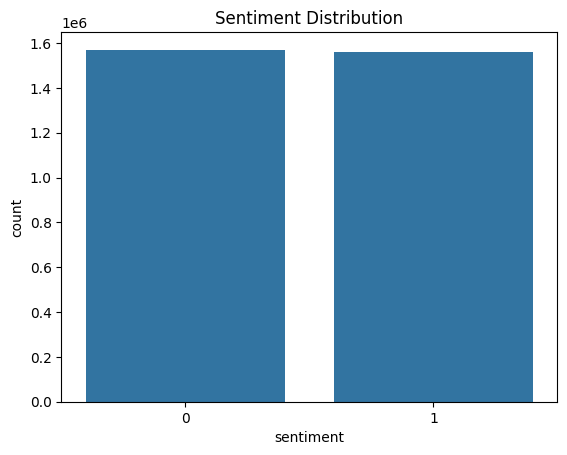

In [10]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [64]:

X = df['tweet']
y = df['sentiment']

# Train-Validation-Test split (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the sizes of each dataset
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 2192038, Validation size: 469723, Test size: 469723


In [11]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:

# tokenize tweets
def tokenize_tweets(tweets):
    return tokenizer(list(tweets), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Tokenize each dataset
train_encodings = tokenize_tweets(X_train)
val_encodings = tokenize_tweets(X_val)
test_encodings = tokenize_tweets(X_test)

# Check sample tokenized data
print("Sample tokenized input IDs from the train set:", train_encodings['input_ids'][0])


Sample tokenized input IDs from the train set: tensor([    0,   298, 41311,  2085,   939,   240,     7,   283,    62,    19,
           10,   731,  1886, 29784,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,   

In [31]:
# Saving tokenized data as PyTorch tensors
torch.save((train_encodings, torch.tensor(y_train.values)), 'train_encodings.pt')
torch.save((val_encodings, torch.tensor(y_val.values)), 'val_encodings.pt')
torch.save((test_encodings, torch.tensor(y_test.values)), 'test_encodings.pt')

print("Tokenized data saved to .pt files.")


Tokenized data saved to .pt files.


## after model training, load the model to evaluate 

In [4]:
# Load the pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Modify the classifier to match the saved model structure using a Sequential layer.
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),  # Dropout as per the trained model
    torch.nn.Linear(model.config.hidden_size, 2)  # Linear layer for binary classification
)

In [6]:
# Load the fine-tuned model weights
model.load_state_dict(torch.load(r'C:\Users\aless\Desktop\final project\Final-Project---Luis-Augustin-Ale\2nd_model.pth'))

C:\Users\aless\AppData\Local\Temp\ipykernel_196412\699189387.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\aless\Desktop\fi

<All keys matched successfully>

In [7]:
# Set the model to evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


In [8]:
# Define the device used to process data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [9]:
# Define the batch size
batch_size = 512 #trying to maximize vram usage


In [10]:
# Load the tokenized validation dataset (make sure the path is correct)
val_encodings, val_labels = torch.load(r'C:/Users/aless/Desktop/final project/Final-Project---Luis-Augustin-Ale/notebooks/val_encodings.pt')


C:\Users\aless\AppData\Local\Temp\ipykernel_196412\1706854417.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_encodings, val_labels = torch.load(r'C:/Users/aless/Des

In [11]:

# Create the validation DataLoader
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)  # adding workers to imrpove cpu usage to avoid bottleneck (8 core = testing with 8 workers )


In [12]:
import time
from torch.cuda.amp import autocast  # Import for mixed precision

# Start timer for inference
start_time = time.time()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []
y_proba = []  # Store probabilities for ROC-AUC

# Set model to no_grad mode for inference
with torch.no_grad():
    # Loop through validation DataLoader
    for step, batch in enumerate(val_loader):
        # Move batch to the device (GPU or CPU)
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Enable mixed precision for faster computation
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Use only the logits for the [CLS] token (first token) for classification
            cls_logits = logits[:, 0, :]  # Extract the [CLS] token logits for each sequence
            
            # Predicted classes from [CLS] token
            predictions = torch.argmax(cls_logits, dim=-1)
            
            # Probabilities for ROC-AUC from [CLS] token
            probabilities = torch.softmax(cls_logits, dim=-1)[:, 1]  # Probabilities for class 1

        # Store predictions and true labels
        all_preds.extend(predictions.cpu().numpy())  # Store binary predictions for each sequence
        all_labels.extend(labels.cpu().numpy())  # Store actual labels
        y_proba.extend(probabilities.cpu().numpy())  # Store probabilities for ROC-AUC

# Total time taken for inference
total_time = time.time() - start_time
print(f"Total inference time: {total_time:.2f} seconds")


C:\Users\aless\AppData\Local\Temp\ipykernel_196412\3577330652.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Total inference time: 259.49 seconds


In [13]:
# Check the shape and some example values
print(f"Predictions (all_preds): {all_preds[:5]}")  # Print first 5 predictions
print(f"Labels (all_labels): {all_labels[:5]}")  # Print first 5 labels


Predictions (all_preds): [1, 0, 0, 1, 0]
Labels (all_labels): [0, 0, 0, 0, 0]


In [40]:
# Flatten predictions (ensure it's a 1D array)
all_preds_flat = np.concatenate([pred.flatten() for pred in all_preds])

In [41]:
# Check shapes and values
print(f"Flattened Predictions (all_preds_flat): {all_preds_flat[:5]}")
print(f"Labels (all_labels): {all_labels[:5]}")

Flattened Predictions (all_preds_flat): [0 0 1 0 0]
Labels (all_labels): [0, 0, 0, 0, 0]


In [19]:
# Print a few predictions and their corresponding labels
print("Predictions sample:", all_preds[:10])
print("True labels sample:", all_labels[:10])

# Check distribution of predictions (if the model is predicting only one class)
unique_preds, counts_preds = np.unique(all_preds, return_counts=True)
pred_class_distribution = dict(zip(unique_preds, counts_preds))
print(f"Predicted Class Distribution: {pred_class_distribution}")


Predictions sample: [1, 0, 0, 1, 0, 1, 1, 1, 0, 0]
True labels sample: [0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Predicted Class Distribution: {0: 242656, 1: 227067}


In [20]:
# Check the distribution of predictions
unique_preds, counts_preds = np.unique(all_preds, return_counts=True)
predictions_distribution = dict(zip(unique_preds, counts_preds))

print(f"Predictions Distribution: {predictions_distribution}")


Predictions Distribution: {0: 242656, 1: 227067}


In [16]:
# Generate classification report 
print("Classification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88    235207
           1       0.89      0.86      0.87    234516

    accuracy                           0.87    469723
   macro avg       0.87      0.87      0.87    469723
weighted avg       0.87      0.87      0.87    469723



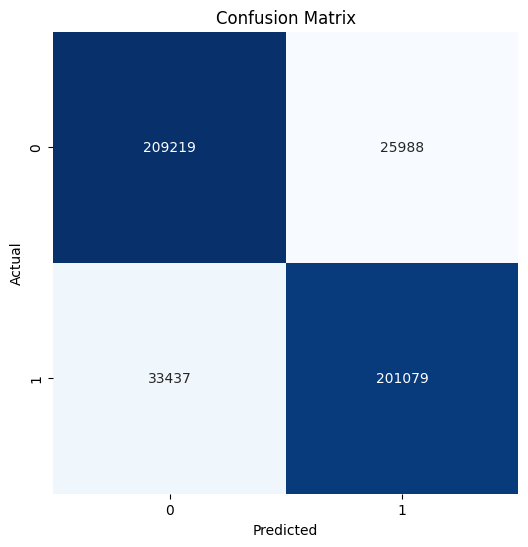

In [21]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [22]:
# Calculate and print the ROC-AUC score
from sklearn.metrics import roc_auc_score

# Ensure you have the probabilities (y_proba) from the model inference step
roc_score = roc_auc_score(all_labels, y_proba)
print(f"ROC-AUC Score: {roc_score:.4f}")


ROC-AUC Score: 0.9473


In [23]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8735


In [24]:
# Precision, recall, and F1-score for the positive class (class 1)
from sklearn.metrics import precision_score, recall_score, f1_score

precision_class_1 = precision_score(all_labels, all_preds, pos_label=1)
recall_class_1 = recall_score(all_labels, all_preds, pos_label=1)
f1_class_1 = f1_score(all_labels, all_preds, pos_label=1)

print(f"Precision (Positive Class): {precision_class_1:.4f}")
print(f"Recall (Positive Class): {recall_class_1:.4f}")
print(f"F1-Score (Positive Class): {f1_class_1:.4f}")


Precision (Positive Class): 0.8855
Recall (Positive Class): 0.8574
F1-Score (Positive Class): 0.8713


In [25]:
# Generate F1-score for both classes
from sklearn.metrics import f1_score

f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"F1-Score (Weighted): {f1:.4f}")


F1-Score (Weighted): 0.8735
